# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
# import miceforest as mf
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [5]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [6]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [7]:
# def create_lineplot_hue(var, hue, title, legend_title, ax1):
#     a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
#     a.columns = ['date', var, hue, 'Freq']
#     a = a[a[var] != 0]
#     sns.lineplot(x='date', y='Freq', 
#             hue=hue, 
#             data=a,
#             ax=ax1)
#     ax1.set_title(title)
#     ax1.set_ylabel('Frequency')
#     ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [8]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

## 1- Data Preparation

In [11]:
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [12]:
data2019_month = {}
data2019 = []

i=1
while  i < 13:
    # data of 2019
    # if (i<4):
    data2019_month["%s" %i] = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-'+str(i).zfill(2)+'-01.csv.gz')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    # if (i>3) and (i<7):
    #     data2019_month["%s" %i] = pd.read_csv(f'output/hospitalisation_data/input_hospitalisatio2019-'+str(i).zfill(2)+'-01.csv.gz')
    #     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    if (i<3) or (i>11):
        data2019_month["%s" %i]['season'] = "Winter"
    elif (i>2) and (i<6):
        data2019_month["%s" %i]['season'] = "Spring"
    elif (i>5) and (i<9):
        data2019_month["%s" %i]['season'] = "Summer"
    elif (i>8) and (i<12):
        data2019_month["%s" %i]['season'] = "Autumn"

    data2019.append(data2019_month["%s" %i])
    i=i+1
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)

data = data2019

In [13]:
data.shape

(120000, 87)

In [14]:
data.sex.value_counts()

F    61003
M    58997
Name: sex, dtype: int64

In [16]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,admitted_date,deregistered_date,died_date,...,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date,season
count,90000,12000,12000,12000,12000,12000,12000,36000,6000,12000,...,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000,120000
unique,40,40,40,13,13,1192,1192,1192,1186,613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4
top,2021-05,2021-08,2020-07,2018-03,2018-04,2019-03-27,2020-07-02,2020-06-28,2019-03-02,2022-04-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01,Winter
freq,2423,358,345,1059,1039,21,20,49,14,112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,30000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,49986.955117,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,28897.508711,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24903.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49929.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75030.000000,NaN,NaN


In [23]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [24]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

#data.CCI.value_counts()

#### 1-2-2- Calculating all meds except abs

In [25]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds_one_month'] - data['antibacterial_brit_one_month']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    79755
2    13569
3    11294
1    10523
4     4217
5      599
6       43
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [26]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
# min_count =  int(((100-perc)/100)*data.shape[0] + 1)
# data = data.drop(['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd'], axis=1, thresh=min_count)
# data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].dropna(axis=1, thresh=min_count)
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].isnull().mean() < perc]
data.shape

(120000, 89)

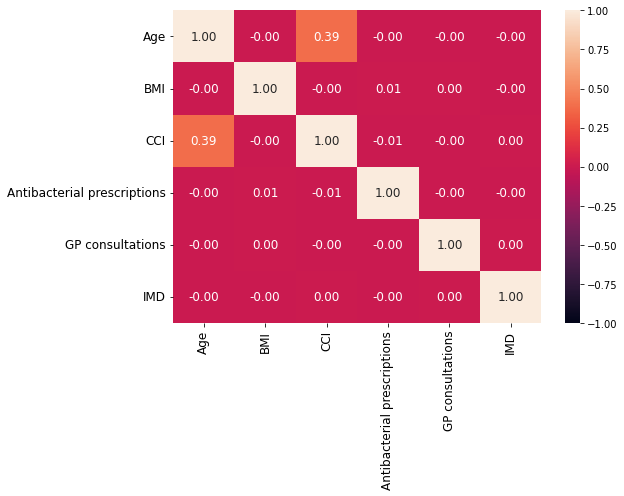

In [27]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd' ]].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

### Adding summary table 